# Research on apartment sales ads

There is the data from a real estate agency. It is an archive of sales ads for realty in St. Petersburg, Russia, and the surrounding areas collected over the past few years. I need to learn how to determine the market value of real estate properties, find the parameters. This will make it possible to build an automated system that is capable of detecting anomalies and fraudulent activity.

There are two different types of data available for every apartment for sale. The first type is a user’s input. The second type is received automatically based upon the map data. For example, the distance from the city center, airport, the nearest park or body of water. 

### Table of Contents <a class="anchor" id="contents"></a>

* [Importing libraries + first glance at data](#chapter1)
* [Data preprocessing](#chapter2)
    * [MISSING VALUES](#section_2_1)
    * [DATA TYPE CHANGE](#section_2_2)
    * [CALCULATIONS FOR ANALYSIS](#section_2_3)
* [Exploratory Data Analysis](#chapter3)
    * [TOTAL AREA](#section_3_1)
    * [PRICE](#section_3_2)
    * [NUMBER OF ROOMS](#section_3_3)
    * [CEILING HEIGHT](#section_3_4)
    * [TIME FOR SALE](#section_3_5)
    * [FACTORS INFLUENCING THE PRICE](#section_3_6)
    * [DOWNTOWN AREA](#section_3_7)
* [General conclusions](#chapter4)

### Importing libraries + first glance at data <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
import calendar
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('real_estate_data_us.csv', sep='\t')

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_posted        23699 non-null  object 
 1   days_listed        20518 non-null  float64
 2   last_price         23699 non-null  float64
 3   bedrooms           23699 non-null  int64  
 4   kitchen_area       21421 non-null  float64
 5   living_area        21796 non-null  float64
 6   total_area         23699 non-null  float64
 7   balconies          12180 non-null  float64
 8   ceiling_height     14504 non-null  float64
 9   floors_total       23613 non-null  float64
 10  floor              23699 non-null  int64  
 11  total_images       23699 non-null  int64  
 12  bike_parking       2775 non-null   object 
 13  is_studio          23699 non-null  bool   
 14  is_open_plan       23699 non-null  bool   
 15  locality_name      23650 non-null  object 
 16  airport_dist       181

,date_posted,days_listed,last_price,bedrooms,kitchen_area,living_area,total_area,balconies,ceiling_height,floors_total,...,bike_parking,is_studio,is_open_plan,locality_name,airport_dist,city_center_dist,park_dist,parks_within_3000,pond_dist,ponds_within_3000
0,2019-03-07T00:00:00,NaN,260000.0,3,25.0,51.0,108.0,NaN,2.70,16.0,...,NaN,False,False,Saint Petersburg,18863.0,16028.0,482.0,1.0,755.0,2.0
1,2018-12-04T00:00:00,81.0,67000.0,1,11.0,18.6,40.4,2.0,NaN,11.0,...,NaN,False,False,Shushary village,12817.0,18603.0,NaN,0.0,NaN,0.0
2,2015-08-20T00:00:00,558.0,103920.0,2,8.3,34.3,56.0,0.0,NaN,5.0,...,NaN,False,False,Saint Petersburg,21741.0,13933.0,90.0,1.0,574.0,2.0
3,2015-07-24T00:00:00,424.0,1298000.0,3,NaN,NaN,159.0,0.0,NaN,14.0,...,NaN,False,False,Saint Petersburg,28098.0,6800.0,84.0,2.0,234.0,3.0
4,2018-06-19T00:00:00,121.0,200000.0,2,41.0,32.0,100.0,NaN,3.03,14.0,...,NaN,False,False,Saint Petersburg,31856.0,8098.0,112.0,2.0,48.0,1.0


**23 699** objects are in the dataframe, some have missing values. Lets examine them more precisily.
- date_posted - seems alright, but probably need to change its format into more pleasant form? (%Y-%m-%d)
- day_listed - check for missings, change type from floating to integer
- last_price - okay
- bedrooms - okay
- kitchen_area - there are missing values but they are fine because it is possible that in the apartment there is no separate area for the kithcen
- living_area - there are some missings, need check because of there is no living area what the place is? plus extremely low spaces (less then 5)
- total_area - seems okay
- balconies - there are missing values meaning that there are no balconies. 5 balconies in 50 sq apartment also seems strange. need closer look
- ceiling_height -  Missing values could be replaced with mean value because the ceiling height is not something that really varies from place to place
- floors_total - change data type, plus there are some missing values which can be replaced with floor number from the next column 'floor', maybe it is not the highest floor in the building but it is enough to replace the missing data. I have also checked if there is a situation when floor is bigger then floors_total - no such values
- total_images - seems ok
- bike_parking - need change to boolean, missings mean lack of parking so can be replaced with 'False'
- is_studio - seems ok
- is_open_plan - seems ok
- locality_name - 49 entries have no locality_name, it would be easier just to delete them and do not try to retrieve the values. check if they are close to city center of Saint Petersburg
- airport_dist - probably more convenient in the form of km, plus there is one cell with 0, need to be replaced with missing values. Other missing values could be replaced according to locality_names (if possible and needed).
- city_center_dist - missing values are hard to retrieve, probably I can leave it like this
- park_dist - missings mean that there are no parks close. im not sure if I need to replace them
- parks_within_3000 - missings can be replaced with 0 because it means that there are no parks with 3 km, change data type from floating to integer
- pond_dist and ponds_within_3000 - the same as with parks

[back to contents](#contents)

### Data preprocessing <a class="anchor" id="chapter2"></a>

#### MISSING VALUES <a class="anchor" id="section_2_1"></a>

For days I filled missing values with zeros

In [4]:
df['days_listed'] = df['days_listed'].fillna(0)

For ceiling_height I have replaced missing values with mean

In [5]:
height_median = df['ceiling_height'].median()
df['ceiling_height'] = df['ceiling_height'].fillna(height_median)
df['ceiling_height'] = df['ceiling_height'].round(decimals=2)
df['ceiling_height'].isnull().sum()

0

floors_total - I have added the values from the floor column assuming that at least it is the information which can be used in analysis and not to loose data

In [6]:
df['floors_total'] = df.apply(
    lambda row: row['floor'] if np.isnan(row['floors_total']) else row['floors_total'],
    axis=1)
df['floors_total'].isnull().sum()

0

For bike parking, distances, areas, parks and ponds I replaced missing values with False or 0.

In [7]:
df['bike_parking'] = df['bike_parking'].fillna(False)

In [8]:
df['parks_within_3000'] = df['parks_within_3000'].fillna(0)

In [9]:
df['ponds_within_3000'] = df['ponds_within_3000'].fillna(0)

There were some rows  with no locality name, again in order not to loose data I have checked that only Saint Petersburg has distance from the city center no more than 15000 and this allowed me to replace some missing cells with 'Saint Petersburg'. The rest 13 lines I dropped.

In [10]:
df['locality_name'] = df['locality_name'].fillna(0)
locality_new = []
for index, row in df.iterrows():
    if ((row['city_center_dist'] < 15000) & (row['locality_name'] == 0)):
        locality_new.append('Saint Petersburg')
    else:
        locality_new.append(row['locality_name'])
df['locality_new'] = locality_new

df.head()
df['locality_new'].isnull().sum()

0

In [11]:
local = df.pivot_table(index='locality_name', values='city_center_dist', aggfunc=['mean', 'min', 'max'])
local.columns = ['mean', 'min', 'max']
local.sort_values(by='min', ascending=True).head(20)

,mean,min,max
locality_name,,,
Saint Petersburg,11601.291571,181.0,29493.0
0,11278.902439,1322.0,41294.0
Shushary village,24243.387615,17012.0,32079.0
Pargolovo village,19924.776758,17994.0,24415.0
Strelna village,23376.113636,21813.0,24134.0
Murino village,21888.000000,21888.0,21888.0
Pushkin,28745.375000,24311.0,35610.0
Levashovo village,25727.000000,25727.0,25727.0
Pesochny village,26475.250000,25867.0,27835.0


In [12]:
df.drop(df[df.locality_new == 0].index, inplace=True)

In [13]:
df['balconies'] = df['balconies'].fillna(0)
df['balconies'].value_counts()
df[df['balconies'] > 2]
df[df['balconies'] == 5]
df.pivot_table(index = 'balconies', values = 'total_area', aggfunc=['mean', 'min', 'max', 'count'])
df[(df['balconies'] > 2) & (df['total_area'] < 100)]
df.loc[(df['balconies'] > 2) & (df['total_area'] < 150), 'balconies'] = 2
df['balconies'].value_counts()

0.0    15261
2.0     4199
1.0     4191
5.0       13
4.0        9
3.0        5
Name: balconies, dtype: int64

#### DATA TYPE CHANGE <a class="anchor" id="section_2_2"></a>

In [14]:
df['date_posted'] = pd.to_datetime(df['date_posted'], format='%Y-%m-%d')

In [15]:
df['days_listed'] = df['days_listed'].astype('int').round(decimals=0)

In [16]:
df['floors_total'] = df['floors_total'].astype('int').round(decimals=0)

In [17]:
df['parks_within_3000'] = df['parks_within_3000'].astype('int').round(decimals=0)

In [18]:
df['ponds_within_3000'] = df['ponds_within_3000'].astype('int').round(decimals=0)

In [19]:
df.dropna(subset=['locality_new'],inplace=True)

I have changed days, floors, number of parks and ponds in integers for more convenient usage.

#### CALCULATIONS FOR ANALYSIS <a class="anchor" id="section_2_3"></a>

In [20]:
#price per square meter
df['price_per_sqm'] = (df['last_price'] / df['total_area']).round(decimals=2)

In [21]:
#extracting months from dates
df['month'] = pd.DatetimeIndex(df['date_posted']).month
df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])

In [22]:
#extracting weekdays
df['weekday'] = df['date_posted'].dt.weekday

def dayNameFromWeekday(weekday):
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    return days[weekday]
df['weekday'] = df['weekday'].apply(dayNameFromWeekday)

In [23]:
#extracting years
df['year'] = pd.DatetimeIndex(df['date_posted']).year

In [25]:
#categorizing by # of floors
def floor_category(row):
    total = row['floors_total']
    number = row['floor']
    if number == 1:
        return 'first'
    elif number == total:
        return 'last'
    else:
        return 'other'

df['floor_category'] = df.apply(floor_category, axis=1)
df.head()

,date_posted,days_listed,last_price,bedrooms,kitchen_area,living_area,total_area,balconies,ceiling_height,floors_total,...,park_dist,parks_within_3000,pond_dist,ponds_within_3000,locality_new,price_per_sqm,month,weekday,year,floor_category
0,2019-03-07,0,260000.0,3,25.0,51.0,108.0,0.0,2.70,16,...,482.0,1,755.0,2,Saint Petersburg,2407.41,Mar,Thursday,2019,other
1,2018-12-04,81,67000.0,1,11.0,18.6,40.4,2.0,2.65,11,...,NaN,0,NaN,0,Shushary village,1658.42,Dec,Tuesday,2018,first
2,2015-08-20,558,103920.0,2,8.3,34.3,56.0,0.0,2.65,5,...,90.0,1,574.0,2,Saint Petersburg,1855.71,Aug,Thursday,2015,other
3,2015-07-24,424,1298000.0,3,NaN,NaN,159.0,0.0,2.65,14,...,84.0,2,234.0,3,Saint Petersburg,8163.52,Jul,Friday,2015,other
4,2018-06-19,121,200000.0,2,41.0,32.0,100.0,0.0,3.03,14,...,112.0,2,48.0,1,Saint Petersburg,2000.00,Jun,Tuesday,2018,other


In [26]:
df['living_ratio'] = (df['living_area'] / df['total_area']).round(decimals=2)
df['kitchen_ratio'] = (df['kitchen_area'] / df['total_area']).round(decimals=2)
df.head()
living_area_median = df['living_ratio'].median()
print('Median of ratio living to total area: ', living_area_median)
kitchen_area_median = df['kitchen_ratio'].median()
print('Median of ratio kitchen to total area: ', kitchen_area_median)

Median of ratio living to total area:  0.57
Median of ratio kitchen to total area:  0.17


In [27]:
kitchen_studio = df[(df.kitchen_area.isnull())& (df['bedrooms'] == 0)].copy()
kitchen_studio['kitchen_area'] = kitchen_studio['kitchen_area'].fillna(0)
total_area = df['total_area']
kitchen_studio['living_area'] = kitchen_studio['living_area'].fillna(total_area)
df = df.drop(df[(df.kitchen_area.isnull()) & (df['bedrooms'] == 0)].index)
frames = [df, kitchen_studio]
df_new = pd.concat(frames)
len(df_new)

23678

In [28]:
df_new['living_area'] = df_new['living_area'].fillna(total_area * living_area_median)
df_new['kitchen_area'] = df_new['kitchen_area'].fillna(total_area * kitchen_area_median)

In [29]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23678 entries, 0 to 23637
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date_posted        23678 non-null  datetime64[ns]
 1   days_listed        23678 non-null  int32         
 2   last_price         23678 non-null  float64       
 3   bedrooms           23678 non-null  int64         
 4   kitchen_area       23678 non-null  float64       
 5   living_area        23678 non-null  float64       
 6   total_area         23678 non-null  float64       
 7   balconies          23678 non-null  float64       
 8   ceiling_height     23678 non-null  float64       
 9   floors_total       23678 non-null  int32         
 10  floor              23678 non-null  int64         
 11  total_images       23678 non-null  int64         
 12  bike_parking       23678 non-null  bool          
 13  is_studio          23678 non-null  bool          
 14  is_ope

[back to contents](#contents)

### Exploratory data analysis <a class="anchor" id="chapter3"></a>

### TOTAL AREA <a class="anchor" id="section_3_1"></a>

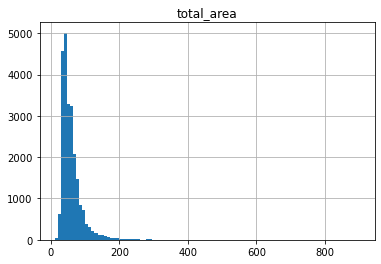

Mean: 60.34
Median: 52.0


In [30]:
df_new.hist('total_area', bins=100)
plt.show()
print('Mean:',round(df_new['total_area'].mean(), 2))
print('Median:', df_new['total_area'].median())

'Total_area' - what we see here: the biggest number of apartments are around 45-50 sq.m. We also have several outliers:
- too small numbers: there are apartments with the area less then 20 sq. m. There could be this kind of apartments like mini-mini studios for one person to live;
- too big numbers: apartments over 400 sq.m. are really rare but still have a right for existence. 
As we can see mean and median are quite close to each other, I am not sure if we really need to get rid of too small and too big apartments.

## PRICE <a class="anchor" id="section_3_2"></a>

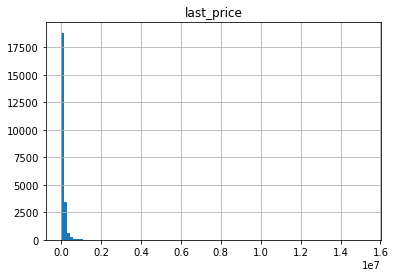

Mean: 130861.71
Median: 93000.0


In [31]:
df.hist('last_price', bins=100)
plt.show()
print('Mean:', round(df_new['last_price'].mean(), 2))
print('Median:', df_new['last_price'].median())

In [32]:
new_price_df = df_new[(df_new['locality_new']=='Saint Petersburg') & (df_new['bedrooms'] == 2) & (df_new['total_area'] > 100)]
len(new_price_df)
new_price_mean = new_price_df['last_price'].mean()
df_new['last_price'] = df_new['last_price'].replace(244, new_price_mean)

I found extremely low number - 244, it is obviously wrong value and not an outlier.  In order to get rid of it I have calculated the mean price for aprarments of similar type: 2 bedroom, located in the city, bigger than 100 sq.m.

## NUMBER OF ROOMS <a class="anchor" id="section_3_3"></a>

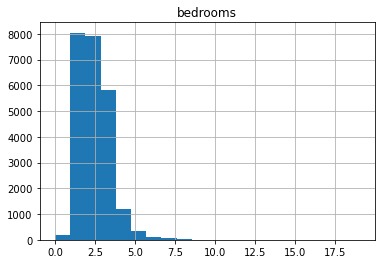

In [33]:
df_new.hist('bedrooms', bins=20)
plt.show()

In [34]:
df_new.pivot_table(index = 'bedrooms', values = 'total_area', aggfunc=['mean', 'min', 'max', 'count'])
df_new[(df_new['bedrooms'] == 0) & (df_new['total_area'] > 100)]
df_new.drop(df_new.loc[df_new['total_area']==371].index, inplace=True)

In [35]:
print('Mean:', round(df_new['bedrooms'].mean(),2))
print('Median:', df_new['bedrooms'].median())

Mean: 2.07
Median: 2.0


So I see one outlier which seems really strange - no bedrooms with 370 sq m area. Additional checks show that there is no information about kitchen, living area. Maybe it is not a place for living, maybe some commercial estate  or it is a mistake in data. So I got rid of it.

## CEILING HEIGHT <a class="anchor" id="section_3_4"></a>

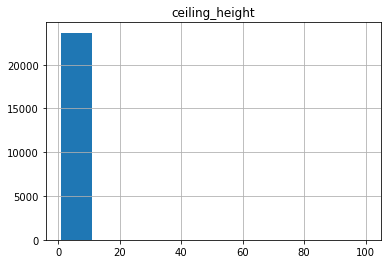

In [36]:
df_new.hist('ceiling_height', bins=10)
plt.show()

In [37]:
df_new.loc[df_new['ceiling_height'] < 2, 'ceiling_height'] = height_median
df_new.loc[df_new['ceiling_height'] > 5, 'ceiling_height'] = height_median

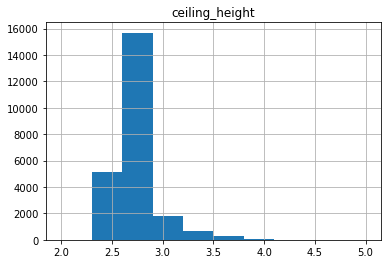

Mean: 2.7
Median: 2.65


In [38]:
df_new.hist('ceiling_height', bins=10)
plt.show()
print('Mean:', round(df_new['ceiling_height'].mean(), 2))
print('Median:', df_new['ceiling_height'].median())

There are 3 entries with ceiling height 1, 1.2, 1,75 it is too small for average person and vice verse 100 metres and every ceiling higher 5-7 metres is hard to believe. I have replaced them with median value - I think it suites more because it is not effected by high values for big apartments.

## TIME FOR SALE  <a class="anchor" id="section_3_5"></a>

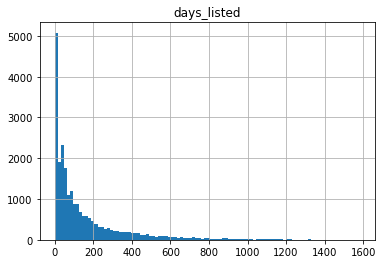

Mean: 156.61
Median: 74.0
Mean for ads listed at least one day: 180.91
Median for ads listed at least one day: 95.0
Mode for ads listed at least one day: 0    45
dtype: int32
Share of ads listed less than a day: 13.43%


In [39]:
df_new.hist('days_listed', bins=100)
plt.show()
print('Mean:', round(df_new['days_listed'].mean(),2))
print('Median:',df_new['days_listed'].median())
print('Mean for ads listed at least one day:', round(df_new[df_new['days_listed'] != 0]['days_listed'].mean(), 2))
print('Median for ads listed at least one day:', round(df_new[df_new['days_listed'] != 0]['days_listed'].median(), 2))
print('Mode for ads listed at least one day:', df_new[df_new['days_listed'] != 0]['days_listed'].mode())
print('Share of ads listed less than a day:','{:,.2%}'.format(df_new[df_new['days_listed'] == 0]['days_listed'].count() / len(df_new)))

So what we see here. There is a significant share of ads listed less than a day - more than 10%. Difficult to decide whether it is a system mistake or indeed these are very desirable apartments which flew as soon as they entered the market. So I assume it is important to exclude these ads from the analysis of time for sale.
Here we are: three numbers showing different values.
Mean 180,9 and histogram show that the mean values is strongly affected by extremely long listed ads. I assume we can name all **the ads listed more than 180,9 as extra slow**.  
As **for the quickest I would choose mode value 45 days** here because it shows the most frequent value in the table and for ads it is suitable measure to evaluate their effectiveness.

[back to contents](#contents)

### FACTORS INFLUENCING THE PRICE <a class="anchor" id="section_3_6"></a>

In [40]:
df_price = df_new[['price_per_sqm', 'bedrooms', 'floor', 'city_center_dist', 'last_price']]
df_price.head()

,price_per_sqm,bedrooms,floor,city_center_dist,last_price
0,2407.41,3,8,16028.0,260000.0
1,1658.42,1,1,18603.0,67000.0
2,1855.71,2,4,13933.0,103920.0
3,8163.52,3,9,6800.0,1298000.0
4,2000.00,2,13,8098.0,200000.0


In [41]:
df_price.corr()

,price_per_sqm,bedrooms,floor,city_center_dist,last_price
price_per_sqm,1.000000,0.055714,0.129114,-0.317716,0.736473
bedrooms,0.055714,1.000000,-0.150761,-0.184975,0.364191
floor,0.129114,-0.150761,1.000000,0.009221,0.027114
city_center_dist,-0.317716,-0.184975,0.009221,1.000000,-0.206822
last_price,0.736473,0.364191,0.027114,-0.206822,1.000000


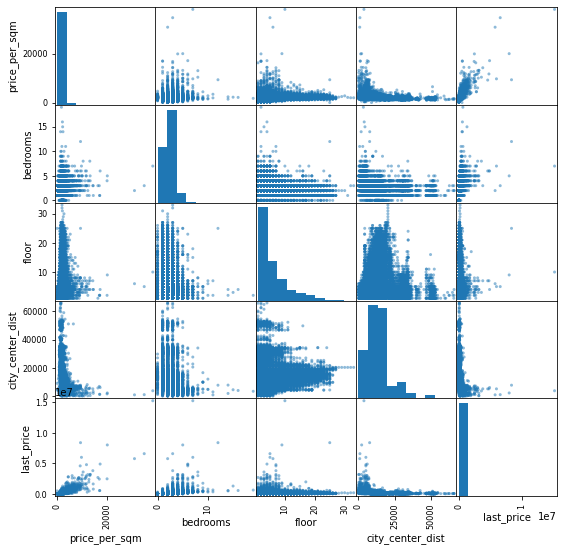

In [42]:
pd.plotting.scatter_matrix(df_price, figsize=(9, 9))
plt.show()

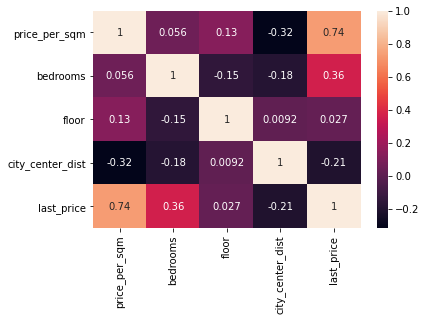

In [43]:
corr_matrix = df_price.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

The strongest and the most logic correlation is between price and price per sq.m. The more expensive is 1 sq.m., the more expensive is the whole apartment.  
There is a kind of tendency between number of bedrooms and the last price but it is weak.  
With number of floor and distance from city center there is no correlation, but interesting that the coeffecient between proximity to city center and price is negative, which means the closer to the center, the higher the prices.

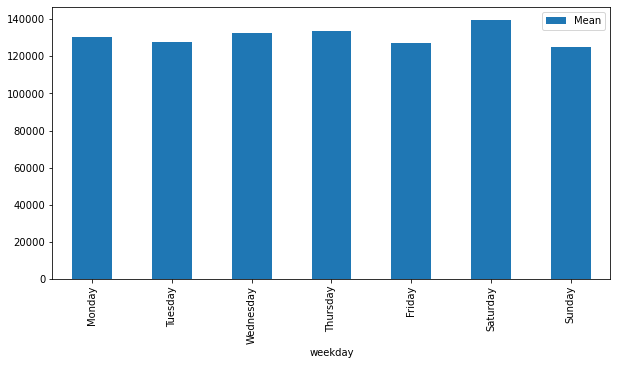

In [44]:
weekday = df_new.pivot_table(index='weekday', values='last_price', aggfunc=['mean', 'median', 'count'])
weekday.columns = ['Mean', 'Median', 'Number of ads']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday = weekday.reindex(days)
weekday.plot(y='Mean', kind='bar', figsize=(10, 5))
plt.show()

Comparing mean values by weekdays show that there is no significant difference between average price and day of listing.

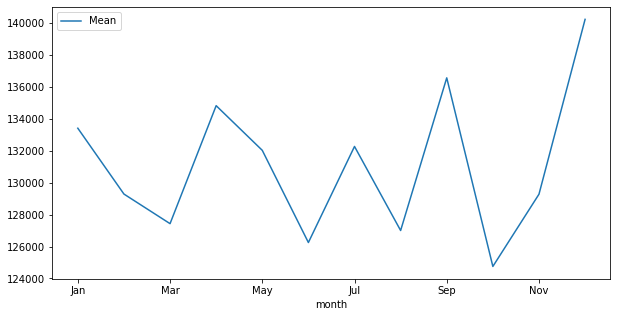

In [45]:
month = df_new.pivot_table(index='month', values='last_price', aggfunc=['mean', 'median', 'count'])
month.columns = ['Mean', 'Median', 'Number of ads']
month.sort_values(by='Mean', ascending=False)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month = month.reindex(months)
month.plot(y='Mean', kind='line', figsize=(10, 5))
plt.show()

What we see from month of listing is that average prices are quite seasonal - there are obvious peaks in April and September - these months are first after closing quarters, maybe buyers have more money. As for December and January they are traditionally slow from the point of the business, it could explain higher prices.

In [46]:
year = df_new.pivot_table(index='year', values='last_price', aggfunc=['mean', 'median', 'count'])
year.columns = ['Mean', 'Median', 'Number of ads']
year = year.sort_index()
year

,Mean,Median,Number of ads
year,,,
2014,241742.715328,154000.0,137
2015,171922.517300,107000.0,1185
2016,136635.206909,91000.0,2779
2017,131706.846689,90000.0,8186
2018,118891.467513,91000.0,8511
2019,135823.227014,101000.0,2879


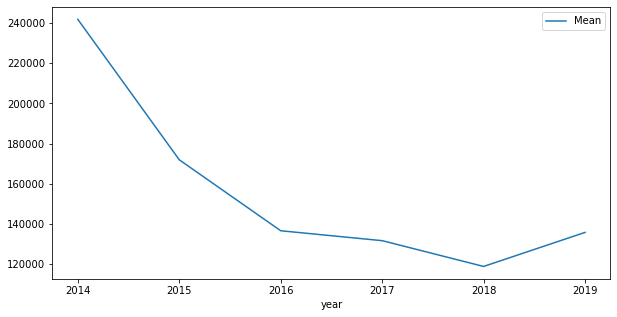

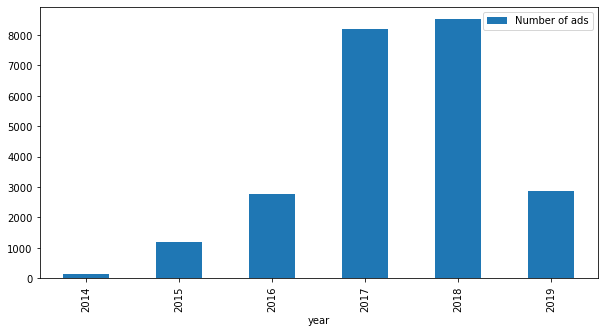

In [47]:
year.plot(y='Mean', kind='line', figsize=(10, 5))
plt.show()
year.plot(y='Number of ads', kind='bar', figsize=(10, 5))
plt.show()

From the very first glance we may assume that the prices dropped down since 2014 but if we check at the same time the number of published ads we will see that in 2014-2015 years there were very low number of ads - this data doesnt alow to make conclusions about price reduction. 

In [48]:
top_locations = df_new.pivot_table(index='locality_new', values='last_price', aggfunc=['count', 'mean', 'min', 'max'])
top_locations.columns = ['Number of ads', 'Mean', 'Minimum price', 'Maximum price']
top_locations.sort_values(by='Number of ads', ascending=False, inplace=True)
top10 = top_locations[:10]
top10

,Number of ads,Mean,Minimum price,Maximum price
locality_new,,,,
Saint Petersburg,15748,161207.087794,23800.0,15260000.0
Murino village,556,73047.228417,34600.0,170000.0
Shushary village,440,82161.636364,30000.0,219800.0
Vsevolozhsk,398,75781.356784,19316.0,488258.0
Pushkin,369,129380.720867,39800.0,840000.0
Kolpino,338,79280.426036,42000.0,738000.0
Pargolovo village,327,89761.495413,28000.0,182800.0
Gatchina,307,69766.732899,17000.0,278000.0
Kudrovo village,299,84683.157191,36000.0,260000.0


So as we see **Saint Petersburg** is the leader from the point of **the highest average price** and **the most expensive apartment** that could be found (among TOP 10 localities).  
**Pushkin** has the comparable average price and the the minimum price is higher than in Saint Petersburg. I can assume that in Saint Petersburg could be any types of apartments.  
**The lowest minimum price** could be found in **Vyborg** - probably because of his proximity from SPb.

###  DOWNTOWN AREA <a class="anchor" id="section_3_7"></a>

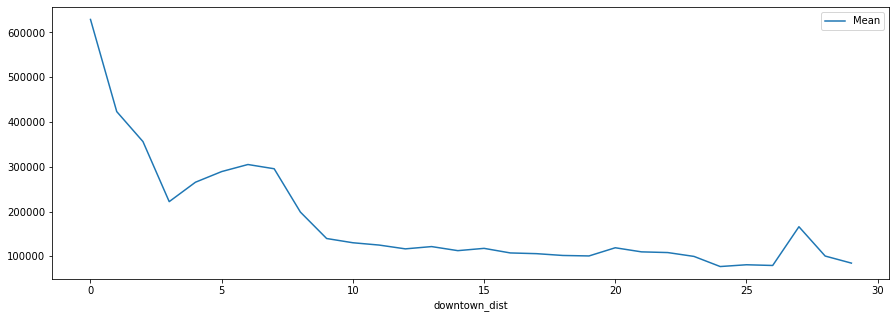

In [49]:
spb = df_new.query('locality_new in "Saint Petersburg"').copy()
spb['downtown_dist'] = spb['city_center_dist'] / 1000
spb['downtown_dist'] = spb['downtown_dist'].round(0)
ave_price_per_km = spb.pivot_table(index='downtown_dist', values='last_price', aggfunc=['mean'])
ave_price_per_km.columns = ['Mean']
ave_price_per_km.plot(y='Mean', kind='line', figsize=(15, 5))
plt.show()

Looking at the graph I would say that downtown area ends aroun 7 km from center. The average prices are significantly decreasing after this point. There is a small peak after 25th km but it could be connected to luxiours suburbian property.

In [50]:
downtown = spb.query('downtown_dist <= 7').copy()
len(downtown)

3540

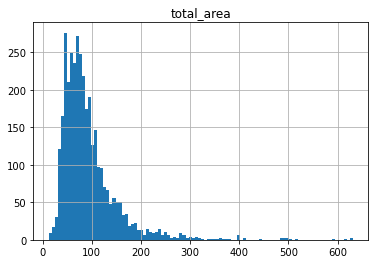

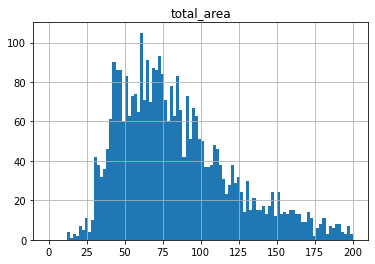

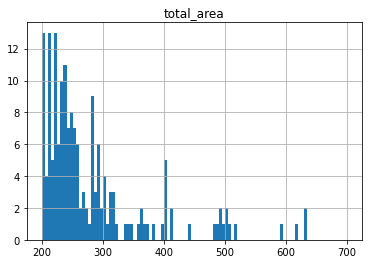

Mean: 93.05
Median: 78.7


In [51]:
downtown.hist('total_area', bins=100)
plt.show()
downtown.hist('total_area', bins=100, range=(0, 200))
plt.show()
downtown.hist('total_area', bins=100, range=(200, 700))
plt.show()
print('Mean:', round(downtown['total_area'].mean(),2))
print('Median:', downtown['total_area'].median())

Of course, mean and median values for downtown area are higher than for the rest of the localities, however, we can see **all range of apartments** from the smallest to the big ones.

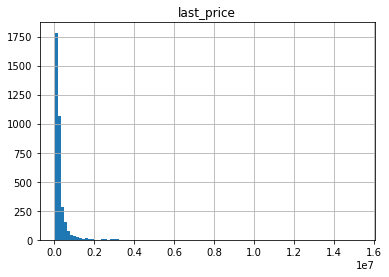

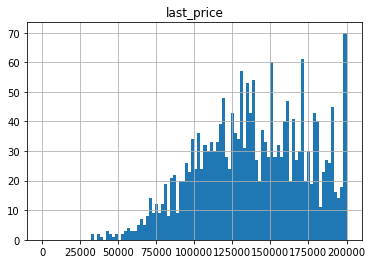

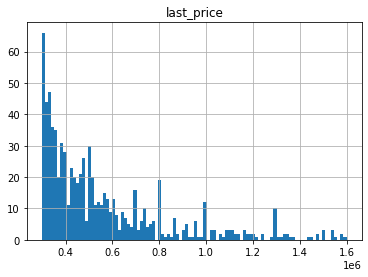

Mean: 297125.04
Median: 184000.0


In [52]:
downtown.hist('last_price', bins=100)
plt.show()
downtown.hist('last_price', bins=100, range=(0, 200000))
plt.show()
downtown.hist('last_price', bins=100, range=(300000, 1600000))
plt.show()
print('Mean:', round(downtown['last_price'].mean(),2))
print('Median:', downtown['last_price'].median())

The prices are significantly higher: **the average price is more than twice higher**. Thats impressive.

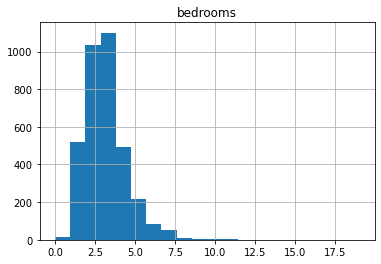

Mean: 2.84
Median: 3.0


In [53]:
downtown.hist('bedrooms', bins=20)
plt.show()
print('Mean:', round(downtown['bedrooms'].mean(),2))
print('Median:', downtown['bedrooms'].median())

If in general the average number of rooms is 2, than for downtown **3-bedroom apartments** are more frequent.

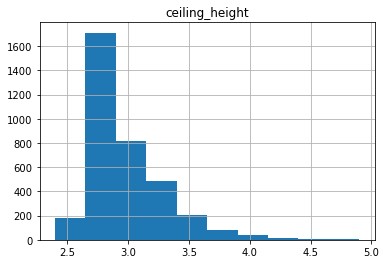

Mean: 2.93
Median: 2.8


In [54]:
downtown.hist('ceiling_height', bins=10)
plt.show()
print('Mean:', round(downtown['ceiling_height'].mean(),2))
print('Median:', downtown['ceiling_height'].median())

The difference in ceiling heights is **insignificant**

In [55]:
downtown_price = df[['bedrooms', 'floor', 'city_center_dist', 'last_price']]
downtown_price.corr()

,bedrooms,floor,city_center_dist,last_price
bedrooms,1.000000,-0.145317,-0.188467,0.364834
floor,-0.145317,1.000000,0.008393,0.028483
city_center_dist,-0.188467,0.008393,1.000000,-0.207071
last_price,0.364834,0.028483,-0.207071,1.000000


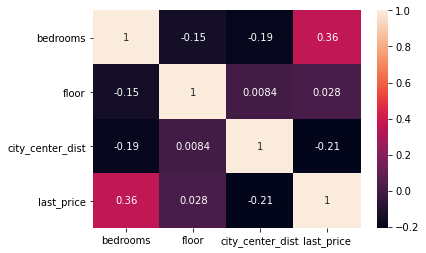

In [56]:
corr_matrix_new = downtown_price.corr()
sn.heatmap(corr_matrix_new, annot=True)
plt.show()

In downtown the situation is slightly different comparing to the overall data. The numbers of bedrooms is still a tendency that influences the price and other factors all doesnt really matter. Probably its connected to some latent factor which we dont see but I can assume it could be the location itself 'downtown' is the main factor defining the price.

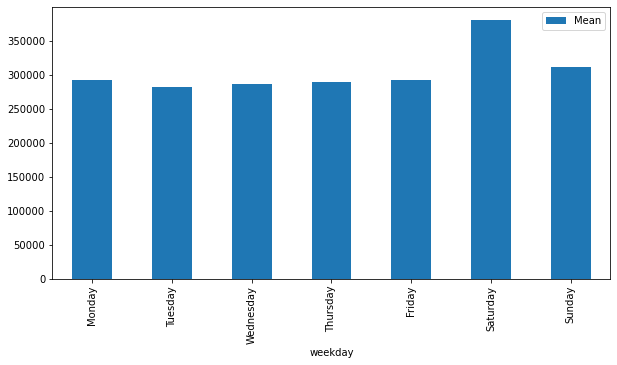

In [57]:
weekday_dtwn = downtown.pivot_table(index='weekday', values='last_price', aggfunc=['mean', 'median', 'count'])
weekday_dtwn.columns = ['Mean', 'Median', 'Number of ads']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_dtwn = weekday_dtwn.reindex(days)
weekday_dtwn.plot(y='Mean', kind='bar', figsize=(10, 5))
plt.show()

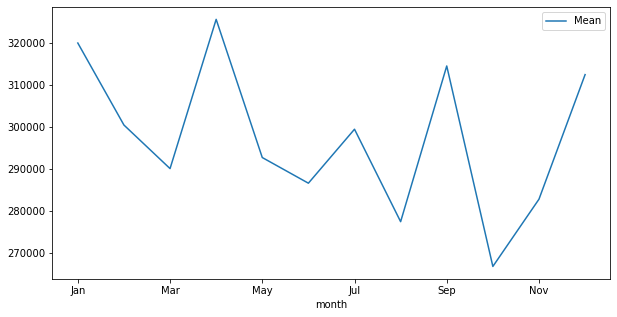

In [58]:
month_dtwn = downtown.pivot_table(index='month', values='last_price', aggfunc=['mean', 'median', 'count'])
month_dtwn.columns = ['Mean', 'Median', 'Number of ads']
month_dtwn.sort_values(by='Mean', ascending=False)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_dtwn = month_dtwn.reindex(months)
month_dtwn.plot(y='Mean', kind='line', figsize=(10, 5))
plt.show()

In [59]:
year_dtwn = df.pivot_table(index='year', values='last_price', aggfunc=['mean', 'median', 'count'])
year_dtwn.columns = ['Mean', 'Median', 'Number of ads']
year_dtwn = year_dtwn.sort_index()
year_dtwn

,Mean,Median,Number of ads
year,,,
2014,241742.715328,154000.0,137
2015,172237.210660,107050.0,1182
2016,136758.861261,91000.0,2775
2017,132558.871275,90000.0,8087
2018,119426.340602,92000.0,8438
2019,136080.002096,102000.0,2862


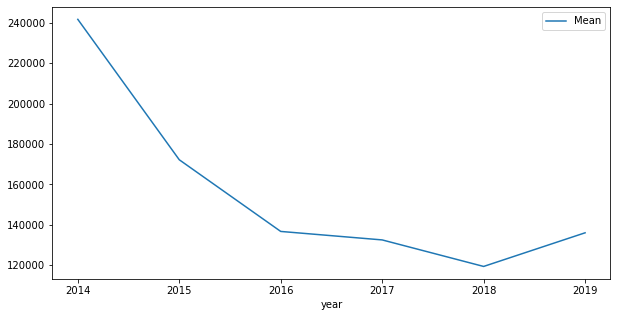

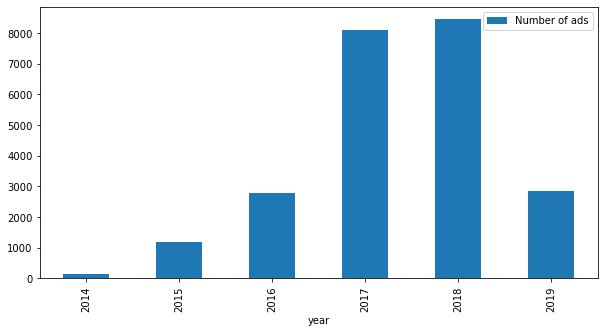

In [60]:
year_dtwn.plot(y='Mean', kind='line', figsize=(10, 5))
plt.show()
year_dtwn.plot(y='Number of ads', kind='bar', figsize=(10, 5))
plt.show()

Regarding ad publication date, there is an interesting difference with the overall data: on Saturdays prices are higher; in April and September the prices are the highest. The tendencies through the years are the same.


### General conclusions <a class="anchor" id="chapter4"></a>

I have investigated the database of real estate ads in Saint Petersburg and its region. The data is sophisticated and is not really full of missings and problem issues.
Factors which influence the average prices of the apartments are price per sq.m., number of bedrooms (tendency), season (April, September, December) and location (regarding analysis of downtown area). Its obvious that in downtown prices are higher, but at the same time there are bigger appartments with bigger number of rooms.
